In [211]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import sklearn 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  # Import the Support Vector Classifier
import scipy.sparse as sp
import torch.optim as optim
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import confusion_matrix


In [212]:
df1 = pd.read_csv('Lending_Club_modelling_data_part1.txt', delimiter='\t')
df2 = pd.read_csv('Lending_Club_modelling_data_part2.txt', delimiter='\t', dtype={'column_name': str}, low_memory=False)
df3 = pd.read_csv('Lending_Club_modelling_data_part3.txt', delimiter='\t')
df4 = pd.read_csv('Lending_Club_modelling_data_part4.txt', delimiter='\t')

#merged data
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
print("Before dropping na: ",df.shape)

# Drop the title column because it is the same information as purpose
df = df.drop('title', axis=1)

# Fill missing values in 'address' column with the wrong address in mort_acc column
df['address'] = df['address'].fillna( '76093 Nicole Parks\r\nEast Donaldfurt, IN 70466')

# Drop application_type, pub_rec, address, initial_list_status, pub_rec_bankruptcies columns since they are useless after checking catboost feature importance
#df = df.drop(['application_type', 'pub_rec', 'address', 'initial_list_status', 'pub_rec_bankruptcies'], axis=1)

# Replace missing values in 'emp_title' column with 'Unknown'
df['emp_title'] = df['emp_title'].fillna('Unknown')

#print rows with missing values, show only if different from 0
print(df.isnull().sum()[df.isnull().sum() > 0])

#replace target variable values with 0 and 1
df['loan_status'] = df['loan_status'].replace({'Charged Off': 1, 'Fully Paid': 0})

# Convert 'issue_d' column to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# Replace values in 'emp_length' column with numerical values
emp_length_map = {
    '< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5,
    '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10
}
df['emp_length'] = df['emp_length'].replace(emp_length_map)

# Correct types of columns
df['revol_util'] = df['revol_util'].replace({'f':'NaN'})
df['revol_util'] = df['revol_util'].astype(float)
df['total_acc'] = df['revol_util'].replace({'INDIVIDUAL':'NaN'})
df['total_acc'] = df['total_acc'].astype(float)
df['mort_acc'] = df['mort_acc'].replace({'76093 Nicole Parks\r\nEast Donaldfurt, IN 70466':'NaN'})
df['mort_acc'] = df['mort_acc'].astype(float)


Before dropping na:  (396030, 25)
emp_length              18301
revol_util                276
mort_acc                37795
pub_rec_bankruptcies      536
dtype: int64


# Net Profit Function

In [213]:
# Define the net_profit function 
def net_profit(y_pred, df):
    # Extract relevant columns from DataFrame as NumPy arrays
    loan_amnt = df['loan_amnt'].values
    int_rate = df['int_rate'].values
    loan_status = df['loan_status'].values
    
    # Who received loans with the model
    index = (y_pred == 0)
    # Who paid back the loans
    index_payback = (loan_status == 0)
    # Who defaulted on the loans
    index_default = (loan_status == 1)
    
    # Calculate profit for loans that were paid back
    paid_back_loans = index & index_payback
    profit_paid_back = loan_amnt[paid_back_loans] * (int_rate[paid_back_loans] / 100)
    total_profit = np.sum(profit_paid_back)
    
    # Calculate loss for loans that defaulted
    defaulted_loans = index & index_default
    loss_defaulted = loan_amnt[defaulted_loans] * 0.5
    total_loss = np.sum(loss_defaulted)
    
    return total_profit - total_loss

# second net profit function with installments

In [214]:
# Define the net_profit function 
def net_profit2(y_pred, df):
    # Extract relevant columns from DataFrame as NumPy arrays
    loan_amnt = df['loan_amnt'].values
    installment = df['installment'].values
    term = df['term'].replace({-1: 36, 1: 60}).values
    loan_status = df['loan_status'].values
    
    # Who received loans with the model
    index = (y_pred == 0)
    # Who paid back the loans
    index_payback = (loan_status == 0)
    # Who defaulted on the loans
    index_default = (loan_status == 1)
    
    # Calculate profit for loans that were paid back
    paid_back_loans = index & index_payback
    profit_paid_back = installment[paid_back_loans]*term[paid_back_loans]-loan_amnt[paid_back_loans]
    total_profit = np.sum(profit_paid_back)
    
    # Calculate loss for loans that defaulted
    defaulted_loans = index & index_default
    loss_defaulted = loan_amnt[defaulted_loans] * 0.5 #paid back %50 of the loan before defalting (assumption)
    total_loss = np.sum(loss_defaulted)
    
    return total_profit - total_loss
    #return total_profit,total_loss,total_profit - total_loss

# Preprocessing

In [215]:
# Convert 'issue_d' column to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# -----------------------------------------------------

# Feature Engineering

In [216]:
df_original=df.copy()
# Separate the data into three groups based on the year ranges
original_training_set = df_original[df_original['issue_d'].dt.year < 2015]
original_validation_set = df_original[df_original['issue_d'].dt.year == 2015]
original_test_set = df_original[df_original['issue_d'].dt.year == 2016]

# Optionally, you may want to reset the index for each subset
original_training_set.reset_index(drop=True, inplace=True)
original_validation_set.reset_index(drop=True, inplace=True)
original_test_set.reset_index(drop=True, inplace=True)

In [217]:
# df['annual_inc']=df['annual_inc']/12 #convert annual income to monthly income
# df['installment_over_income'] = df['installment'] / df['annual_inc']
# df['installment_over_income'] = df['installment_over_income'].replace([np.inf, -np.inf], np.nan)
# df.drop('installment', axis=1, inplace=True) #drop this column as it is redundant
# df.drop('int_rate', axis=1, inplace=True) #redundant
# df.drop('loan_amnt', axis=1, inplace=True)
# df.drop('annual_inc', axis=1, inplace=True) #drop this column as it is redundant



# -----------------------------------------------------

In [218]:


# Convert term to float
df['term'] = df['term'].str.replace(' months', '').astype(float)

# Separate the data into three groups based on the year ranges
training_set = df[df['issue_d'].dt.year < 2015]
validation_set = df[df['issue_d'].dt.year == 2015]
test_set = df[df['issue_d'].dt.year == 2016]

# Optionally, you may want to reset the index for each subset
training_set.reset_index(drop=True, inplace=True)
validation_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)

# Print the number of rows in each group
print("Number of rows in training set:", len(training_set))
print("Number of rows in validation set:", len(validation_set))
print("Number of rows in test set:", len(test_set))

Number of rows in training set: 273678
Number of rows in validation set: 94264
Number of rows in test set: 28088


In [219]:
categorical_columns = training_set.select_dtypes(include='object').columns.tolist()
print(categorical_columns)
numerical_columns = training_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(numerical_columns)
print(len(numerical_columns)+len(categorical_columns))

['emp_title', 'home_ownership', 'verification_status', 'purpose', 'earliest_cr_line', 'initial_list_status', 'application_type', 'address']
['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'loan_status', 'dti', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']
23


In [220]:
num_training_set = training_set[numerical_columns].drop('loan_status', axis=1)
numerical_columns_without_loan_status= num_training_set.columns
imputer = IterativeImputer(random_state=0)
imputer.fit(num_training_set)

imputed_array = imputer.transform(num_training_set[numerical_columns_without_loan_status])
num_training_set = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)

# Concatenate imputed features with target variable
training_set[numerical_columns_without_loan_status] = num_training_set

# Check for missing values in the training set
print("Missing values in the training set:")
print(training_set.isnull().sum()[training_set.isnull().sum() > 0])

Missing values in the training set:
Series([], dtype: int64)


/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72555/1054685528.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set[numerical_columns_without_loan_status] = num_training_set


For xgboost, I use label encoding to encode the categorical columns.

In [221]:
# Create a label encoder instance
label_encoder = LabelEncoder()

# # Encode categorical columns using LabelEncoder
# label_encoders = {}
# for col in categorical_columns:
#     label_encoders[col] = LabelEncoder()
#     training_set.loc[:, col] = label_encoders[col].fit_transform(training_set[col])

It might be sufficient to tell the encoder which ones are categorical otherwise. 

In [222]:

# Convert categorical columns to category type
training_set[categorical_columns] = training_set.loc[:, categorical_columns].astype('category')

# Convert 'issue_d' column to category type
training_set['issue_d'] = training_set['issue_d'].astype('category')


/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72555/4104939919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set[categorical_columns] = training_set.loc[:, categorical_columns].astype('category')
/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72555/4104939919.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['issue_d'] = training_set['issue_d'].astype('category')


# Model

In [223]:
# Supported tree methods are `approx` and `hist`.
clf = xgb.XGBClassifier(tree_method="hist", 
                        enable_categorical=True, 
                        objective="binary:logistic",
                        device="cuda", 
                        scale_pos_weight=4, 
                        n_estimators=300, 
                        max_depth=5, 
                        learning_rate=0.1)

# Fit the model
X_train_xgb = training_set.drop('loan_status', axis=1)
y_train_xgb = training_set['loan_status']

clf.fit(X_train_xgb, y_train_xgb)

# Must use JSON/UBJSON for serialization, otherwise the information is lost.
clf.save_model("xgboost-model.json")

In [224]:
y_pred_train_xgb = clf.predict(X_train_xgb)

# Confusion matrix
conf_matrix = confusion_matrix(y_train_xgb, y_pred_train_xgb)

# Evaluate model
print("Training set: ")
accuracy = accuracy_score(y_train_xgb, y_pred_train_xgb)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_train_xgb, y_pred_train_xgb))

TN, FP, FN, TP = conf_matrix.ravel()

true_negative_rate = TN / (TN + FP)
true_positive_rate = TP / (TP + FN)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)

# true_negatives = np.sum((y_train_xgb == 1) & (y_pred_train_xgb == 1))
# false_negatives = np.sum((y_train_xgb == 0) & (y_pred_train_xgb == 1))
# true_positives = np.sum((y_train_xgb == 0) & (y_pred_train_xgb == 0))   
# false_positives = np.sum((y_train_xgb == 1) & (y_pred_train_xgb == 0)) #important!

# true_positive_rate = true_positives / (true_positives + false_negatives)
# false_positive_rate = false_positives / (false_positives + true_negatives)
# print("True Positive Rate:", true_positive_rate)
# print("False Positive Rate:", false_positive_rate)
# print(f"Confusion Matrix:\n{conf_matrix}")

Training set: 
Accuracy: 0.7750933578877367
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85    223166
           1       0.44      0.74      0.55     50512

    accuracy                           0.78    273678
   macro avg       0.68      0.76      0.70    273678
weighted avg       0.84      0.78      0.79    273678

True Negative Rate (non default as non default): 0.7832868806180153
True Positive Rate (default as default): 0.7388937282229965


Profit improvement in the training set

In [225]:
# net profit of the model
net_train_profit_model=net_profit(y_pred_train_xgb,original_training_set)
print("Net profit:", net_train_profit_model)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(original_training_set))
net_train_profit=net_profit(zeros,original_training_set)
print("Net profit original:", net_train_profit)

improved_profit=net_train_profit_model-net_train_profit
print("Improved profit:", improved_profit)

Net profit: 190244307.39749998
Net profit original: 33980007.84500003
Improved profit: 156264299.55249995


feature importance

In [226]:
# Get feature importances
feature_importances = clf.feature_importances_

#decreasing order
indices = np.argsort(feature_importances)[::-1]
# Print the feature ranking
print("Feature importances:")
for f in range(X_train_xgb.shape[1]):
    print(f"{f + 1}.  {X_train_xgb.columns[indices[f]]}: {feature_importances[indices[f]]}")



Feature importances:
1.  term: 0.27806100249290466
2.  int_rate: 0.21050836145877838
3.  emp_title: 0.11834815889596939
4.  annual_inc: 0.06784633547067642
5.  address: 0.05829198658466339
6.  earliest_cr_line: 0.05480900779366493
7.  dti: 0.03612463176250458
8.  issue_d: 0.035331230610609055
9.  home_ownership: 0.026359738782048225
10.  mort_acc: 0.02452663704752922
11.  loan_amnt: 0.018204927444458008
12.  purpose: 0.015084885060787201
13.  verification_status: 0.012088652700185776
14.  installment: 0.011111084371805191
15.  open_acc: 0.008140536025166512
16.  revol_util: 0.005750676151365042
17.  revol_bal: 0.005515983793884516
18.  pub_rec_bankruptcies: 0.0054958355613052845
19.  emp_length: 0.003232738468796015
20.  initial_list_status: 0.002845288021489978
21.  pub_rec: 0.0023222966119647026
22.  total_acc: 0.0
23.  application_type: 0.0


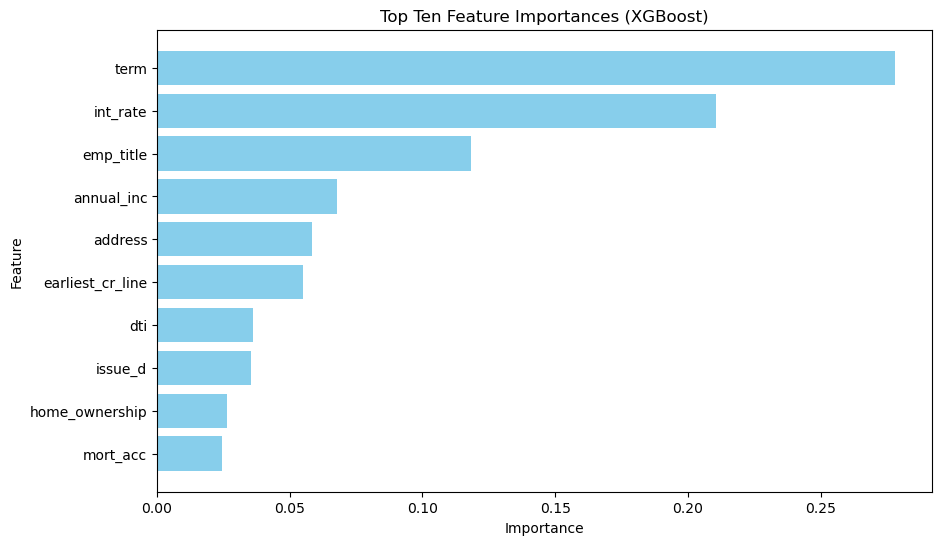

In [227]:
# Extract the names and importance values of the top ten features
top_features = [X_train_xgb.columns[idx] for idx in indices[:10]]
top_importances = feature_importances[indices[:10]]

# Plotting the top ten features and their importances
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Ten Feature Importances (XGBoost)')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

validation set

In [228]:
# Convert categorical columns to category type
validation_set[categorical_columns] = validation_set.loc[:, categorical_columns].astype('category')

# Convert 'issue_d' column to category type
validation_set['issue_d'] = validation_set.loc[:,'issue_d'].astype('category')

/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72555/1986969542.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set[categorical_columns] = validation_set.loc[:, categorical_columns].astype('category')
/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72555/1986969542.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set['issue_d'] = validation_set.loc[:,'issue_d'].astype('category')


In [229]:
X_val = validation_set.drop("loan_status", axis=1)
y_val = validation_set["loan_status"]

# Impute missing values in the validation set
imputed_array = imputer.transform(X_val[numerical_columns_without_loan_status])
intermediate = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)
X_val[numerical_columns_without_loan_status] = intermediate

# Predictions
y_pred_val = clf.predict(X_val)

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

# Evaluate model
print("Validation set: ")
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_val, y_pred_val))

TN, FP, FN, TP = conf_matrix.ravel()

true_negative_rate = TN / (TN + FP)
true_positive_rate = TP / (TP + FN)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)


# true_negatives = np.sum((y_val == 1) & (y_pred_val == 1))
# false_negatives = np.sum((y_val == 0) & (y_pred_val == 1))
# true_positives = np.sum((y_val == 0) & (y_pred_val == 0))   
# false_positives = np.sum((y_val == 1) & (y_pred_val == 0)) #important!

# true_positive_rate = true_positives / (true_positives + false_negatives)
# false_positive_rate = false_positives / (false_positives + true_negatives)
# print("True Positive Rate:", true_positive_rate)
# print("False Positive Rate:", false_positive_rate)
# print(f"Confusion Matrix:\n{conf_matrix}")

Validation set: 
Accuracy: 0.6742552830348808
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77     70791
           1       0.39      0.57      0.46     23473

    accuracy                           0.67     94264
   macro avg       0.61      0.64      0.62     94264
weighted avg       0.72      0.67      0.69     94264

True Negative Rate (non default as non default): 0.7101043918012176
True Positive Rate (default as default): 0.566139820218975


Net Profit improvement in the validation set 

In [230]:
# net profit of the model
net_val_profit_model=net_profit(y_pred_val,original_validation_set)
print("Net profit:", net_val_profit_model)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(original_validation_set))
net_val_profit=net_profit(zeros,original_validation_set)
print("Net profit original:", net_val_profit)

improved_profit=net_val_profit_model-net_val_profit
print("Improved profit:", improved_profit)

Net profit: 3048747.575000003
Net profit original: -48272015.629999995
Improved profit: 51320763.205


# test set


In [231]:
# Convert categorical columns to category type
test_set[categorical_columns] = test_set.loc[:, categorical_columns].astype('category')

# Convert 'issue_d' column to category type
test_set['issue_d'] = test_set.loc[:,'issue_d'].astype('category')

/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72555/1533874959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[categorical_columns] = test_set.loc[:, categorical_columns].astype('category')
/var/folders/l6/8b55cv6j40b20nltsdxdq57h0000gn/T/ipykernel_72555/1533874959.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['issue_d'] = test_set.loc[:,'issue_d'].astype('category')


In [232]:
X_test = test_set.drop("loan_status", axis=1)
y_test = test_set["loan_status"]

# Impute missing values in the validation set
imputed_array = imputer.transform(X_test[numerical_columns_without_loan_status])
intermediate = pd.DataFrame(imputed_array, columns=numerical_columns_without_loan_status)
X_test[numerical_columns_without_loan_status] = intermediate

# Predictions
y_pred_test = clf.predict(X_test)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Evaluate model
print("Test set: ")
accuracy = accuracy_score(y_test, y_pred_test)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_test))

TN, FP, FN, TP = conf_matrix.ravel()

true_negative_rate = TN / (TN + FP)
true_positive_rate = TP / (TP + FN)
print("True Negative Rate (non default as non default):", true_negative_rate)
print("True Positive Rate (default as default):", true_positive_rate)


# true_negatives = np.sum((y_val == 1) & (y_pred_val == 1))
# false_negatives = np.sum((y_val == 0) & (y_pred_val == 1))
# true_positives = np.sum((y_val == 0) & (y_pred_val == 0))   
# false_positives = np.sum((y_val == 1) & (y_pred_val == 0)) #important!

# true_positive_rate = true_positives / (true_positives + false_negatives)
# false_positive_rate = false_positives / (false_positives + true_negatives)
# print("True Positive Rate:", true_positive_rate)
# print("False Positive Rate:", false_positive_rate)
# print(f"Confusion Matrix:\n{conf_matrix}")

Test set: 
Accuracy: 0.6456849900313301
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.66      0.76     24400
           1       0.20      0.56      0.29      3688

    accuracy                           0.65     28088
   macro avg       0.55      0.61      0.53     28088
weighted avg       0.81      0.65      0.70     28088

True Negative Rate (non default as non default): 0.6592213114754099
True Positive Rate (default as default): 0.5561279826464208


Net profit improvement in the test set

In [233]:
# net profit of the model
net_test_profit_model=net_profit(y_pred_test,original_test_set)
print("Net profit:", net_test_profit_model)

# Create vector of 0s (i.e. everyone receievd the loan in the training set) of size equal to the number of rows in the training set 
zeros=np.zeros(len(original_test_set))
net_test_profit=net_profit(zeros,original_test_set)
print("Net profit original:", net_test_profit)

improved_profit=net_test_profit_model-net_test_profit
print("Improved profit:", improved_profit)

Net profit: 12074169.5625
Net profit original: 20667631.3575
Improved profit: -8593461.795000002
